In [11]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.svm import SVC
import pywt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import preprocessing
import seaborn as sns

import tensorflow as tf
# import tensorflow_addons as tfa

import os

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.9.1


In [90]:
# Creation de la data complete

images = []
labels = []

datasets = ['phonixclean','mmuclean','casiaclean','iitdclean','nothing']
start = [3,3,5,3,0]

for data, s in zip(datasets, start):
    for root, dirr, imgs in os.walk(f'data/cleaned/augm/{data}'):
            for img in imgs:
                if ((img.endswith('bmp'))or (img.endswith('png')) or (img.endswith('jpg'))) :
                    path = os.path.join(root,img)  
                    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    images.append(image)
                    labels.append(f'{data[:3]}{img[:s]}')

LE = preprocessing.LabelEncoder()
labels_id = list(le.fit_transform(labels))
labels_dic= {k:v for k,v in zip(labels,labels_id)}
max(labels_id)

988

In [104]:
f , n = np.unique(labels_id, return_counts=True) 
r = np.where(n == min(n))[0]
for i in range(len(r)):
    print([k for (k,v) in labels_dic.items() if v == r[i]])

['casS5049']
['casS5524']
['casS5569']
['casS5601']
['casS5606']
['casS5607']
['casS5621']
['casS5639']
['casS5689']
['casS5695']
['casS5769']
['casS5792']
['casS5850']
['casS5885']
['casS5886']
['casS5917']
['casS5930']
['casS5974']
['casS5976']
['casS5977']
['casS5980']
['casS5997']


c:\Users\21379\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

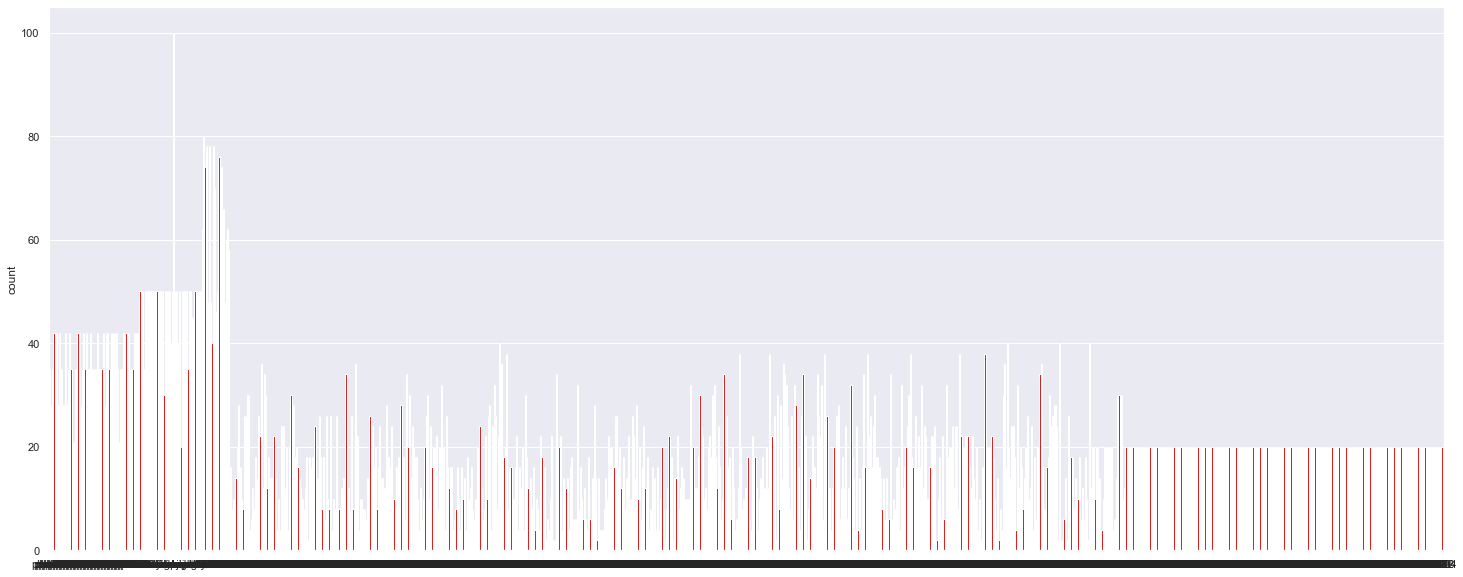

In [81]:
sns.set(rc={'figure.figsize':(25,10)})
sns.countplot(labels, color='red')

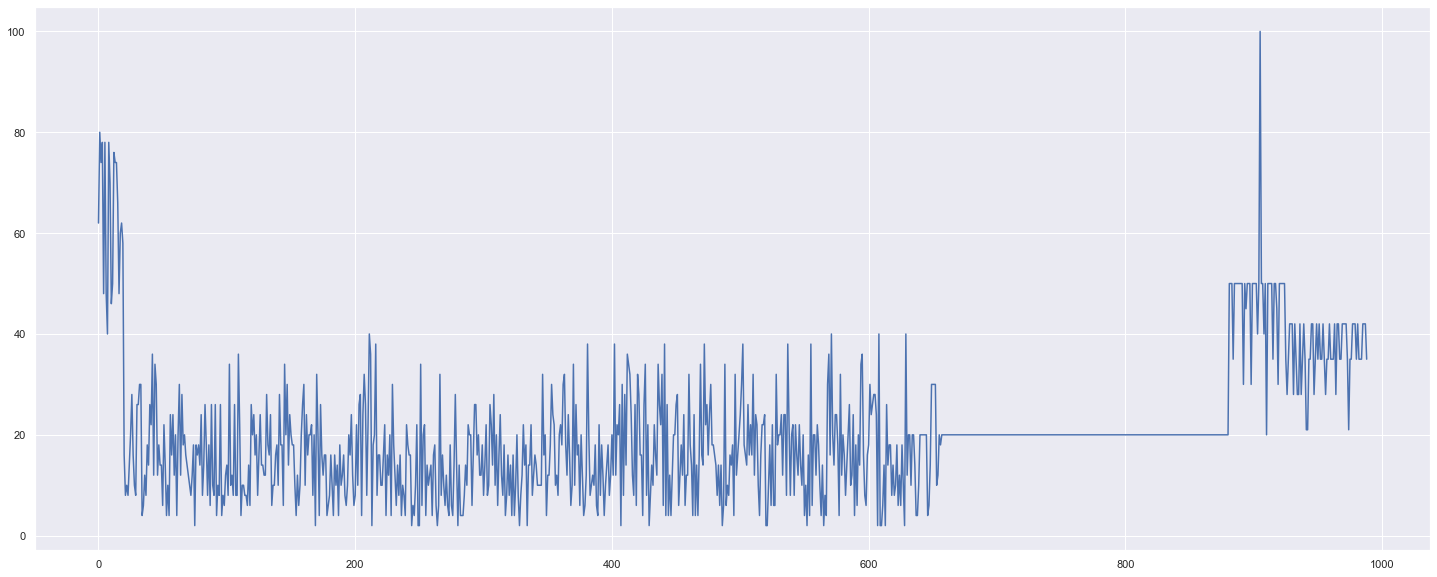

2

In [101]:
f, n = np.unique(labels_id, return_counts=True)
plt.figure(figsize=(25,10))
plt.plot(f,n)
plt.show()
min(n)

In [114]:
# to balance classes 
data_bal=[]
labels_bal=[]
for i,j in zip(labels,images) :
    if (labels_bal.count(i)<21):
        data_bal.append(j)
        labels_bal.append(i)
        
labels_id22 = list(LE.fit_transform(labels_bal))

num_classes = max(labels_id22)+1
print(f'nbr of classes is {num_classes}')    
print(len(data_bal))       

nbr of classes is 989
16076


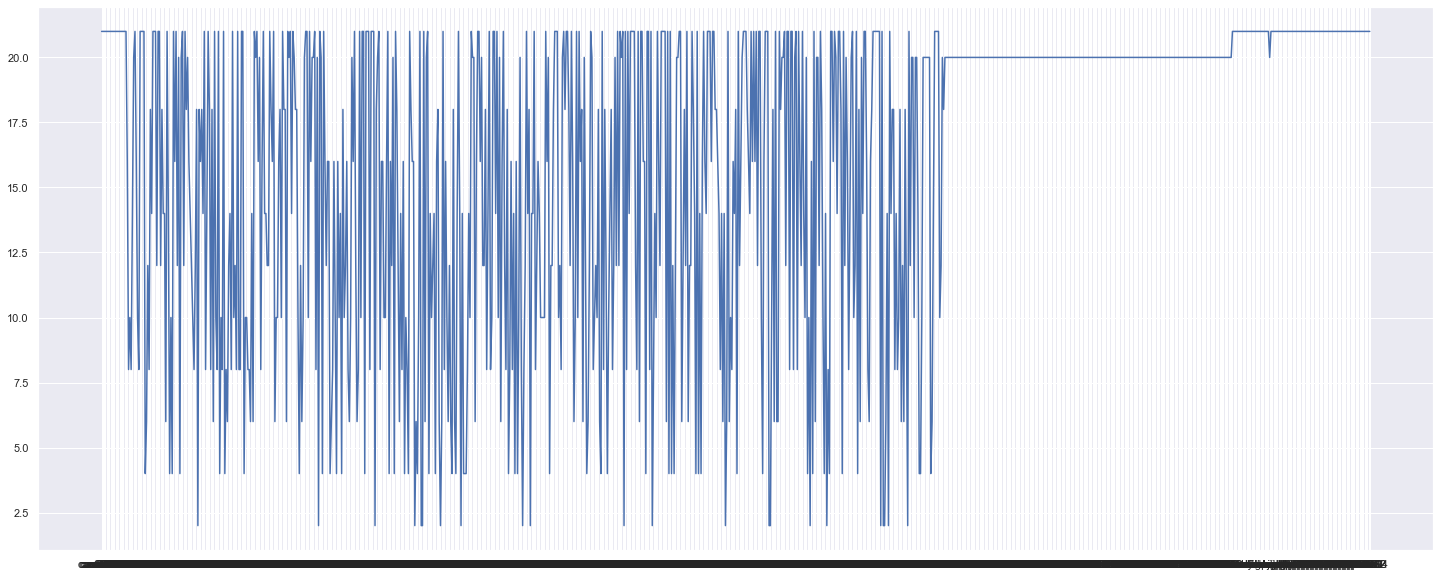

2

In [111]:
f, n = np.unique(labels_bal, return_counts=True)
plt.figure(figsize=(25,10))
plt.plot(f,n)
plt.show()
min(n)     

In [118]:
data_bal = np.array(data_bal)
labels_id22 = np.array(labels_id22) 

In [119]:
xtr, xts, ytr, yts = train_test_split(data_bal,labels_id22, test_size=0.2)

In [ ]:
METRICS = [tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),      # hadi haka ay tsra fiha problem idk why
           tf.keras.metrics.AUC(name='auc'),   
           tfa.metrics.F1Score(num_classes=108)]     # 52 ta3 AMF lba9i casia
EPOCHS = 10

In [ ]:
# dynamic learning rate
def exponential_decay(lr0, s):     # i need to search what is s and wch kayen type of learning rate schedulers mais mzl i didnt use it yet hada but fhamt wch aw sari.
    def exponential_decay_fn(epoch):       # this is an inner function, 3ndhom many uses hado such as : encapsulation and preserve the inner function from ga3 wch ysra bara l outter function
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)   # callbacks : fct li they take as argument other functions

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

In [130]:
def model (dropout = 0) :
    CNN = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(128,128,1)),
        tf.keras.layers.Conv2D(96, (11,11), strides = (4,4), activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.ZeroPadding2D(padding= (2,2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.ZeroPadding2D(padding= (1,1)),
        tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
                                ])
    CNN.compile( optimizer='adam', loss="sparse_categorical_crossentropy",  metrics= 'accuracy')
    return CNN

# tfa.metrics.F1Score(num_classes= 44, average='micro')
# CNN.summary()
    

In [ ]:
# from sklearn.model_selection import cross_validate

# _scoring = ['accuracy', 'precision', 'recall', 'f1']
# results = cross_validate(estimator=CNN,
#                                X=xtr,
#                                y=ytr,
#                                cv= 5,
#                                scoring=_scoring,
#                                return_train_score=True)

In [ ]:
# pipe = Pipeline([('CNN', CNN), ('svc', SVC())])   # matemchich .... pipeline yaccepti ghir transformers, and cnn hadik marahich transformer so we need to find kifch nmechoha
# pipe.fit(xtr,ytr)

In [120]:
# CNN training   (we need to do it ki b svm ki blach)
CNN.fit(
    xtr,ytr,
    # batch_size = 128,
    # validation_data=xval,      # xval necreyiha apres
    #callbacks=[lr_scheduler, my_callback],
    epochs=20
)

Epoch 1/20
402/402 [==============================] - 57s 127ms/step - loss: 6.8872 - accuracy: 0.0019
Epoch 2/20
402/402 [==============================] - 50s 124ms/step - loss: 6.8340 - accuracy: 0.0016
Epoch 3/20
402/402 [==============================] - 52s 129ms/step - loss: 6.8253 - accuracy: 0.0019
Epoch 4/20
402/402 [==============================] - 50s 125ms/step - loss: 6.8145 - accuracy: 0.0019
Epoch 5/20
402/402 [==============================] - 49s 123ms/step - loss: 6.8240 - accuracy: 0.0018
Epoch 6/20
402/402 [==============================] - 49s 122ms/step - loss: 6.8225 - accuracy: 0.0013
Epoch 7/20
402/402 [==============================] - 50s 123ms/step - loss: 6.8229 - accuracy: 9.3313e-04
Epoch 8/20
402/402 [==============================] - 50s 124ms/step - loss: 6.8263 - accuracy: 0.0017
Epoch 9/20
402/402 [==============================] - 50s 124ms/step - loss: 6.8187 - accuracy: 0.0014
Epoch 10/20
402/402 [==============================] - 49s 121ms/step

In [121]:
loss, acc = CNN.evaluate(xts,yts)

101/101 [==============================] - 4s 28ms/step - loss: 6.8885 - accuracy: 0.0000e+00


In [131]:
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))    

In [137]:
# cross val ( before training)
model = KerasClassifier(build_fn=model)
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [20,30,40],
    'dropout_rate': [0.0, 0.10, 0.20, 0.30],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'accuracy', cv=5)
grid_result = grid.fit(data_bal,labels_id22)  # fit the full dataset as we are using cross validation 

display_cv_results(grid_result)

C:\Users\21379\AppData\Local\Temp\ipykernel_4728\2471689455.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=model)


AttributeError: 'KerasClassifier' object has no attribute '__call__'

In [ ]:
CNN.pop() # it will remove the last layer
CNN.summary() # check the network 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 19, 19, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 16)        13840     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                        

In [ ]:
# feature extraction with wavelet

WaveletTrain = []
WaveletTest = []

for i in range(len(xtr)):
  LLtr = pywt.dwt2(xtr[i], 'bior2.2' )[0].astype('uint8')
  LLtr = np.reshape( LLtr , (LLtr.shape[0]*LLtr.shape[1],))
  WaveletTrain.append(LLtr) 

for k in range(len(xts)):
  LLts = pywt.dwt2(xtr[i], 'bior2.2' )[0].astype('uint8')
  LLts = np.reshape( LLts , (LLts.shape[0]*LLts.shape[1],))
  WaveletTest.append(LLts)
 
WTr_feat = np.array(WaveletTrain)
WTs_feat = np.array(WaveletTest)

In [ ]:
WTr_feat.shape

(336, 4356)

In [ ]:
CNN_train_feat = CNN(xtr)      # tmed vecteur fih 751 lignes (nbr des images) et chaque lignes c l features 
CNN_test_feat = CNN(xts)

train_feat = np.hstack((CNN_train_feat, WTr_feat))    # Wtr c features men wavelat jayin de la forme  tan chaque ligne image, aya donc nconcateniw horzotalement bch yjona ga3 l features
test_feat = np.hstack((CNN_test_feat, WTs_feat))


In [ ]:
print(train_feat.shape)
print(ytr.shape)

(336, 8452)
(336,)


In [ ]:
clf = SVC()
clf.fit(CNN_train_feat, ytr)
pred = clf.predict(CNN_test_feat)

In [ ]:
clf1 = SVC()
clf1.fit(train_feat, ytr)
pred1 = clf.predict(test_feat)

Accuracy :  0.03571428571428571


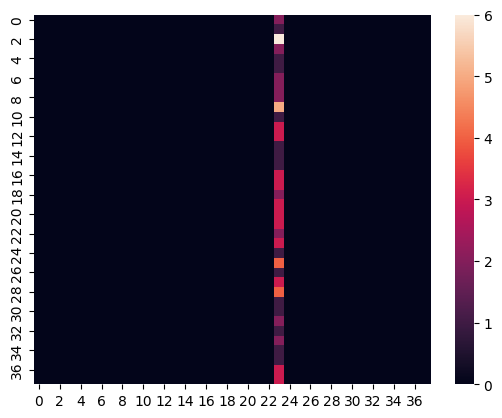

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

cm = confusion_matrix(yts,pred1)
heatmap(cm)

accuracy = float(cm.diagonal().sum())/len(yts)
print("Accuracy : ", accuracy)

Results : EPOCHS = 20
- CNN pure : acc = 0.40 (0.28)
- CNN brk + svm (sans dense) : acc = 0.367
- 2 dense (4000 + 2000 ) + svm : acc = 0.44  (0.01)
- 1 dense (4000) + svm : acc = 0.61

- 2 dense + wavelet + svm : acc = 0.005319148936170213
- 1 dense + wavelet + svm : acc = 0.015957446808510637

Conclusion : mafihach wavelet for feature extraction
i think we need ndiro cross validation psk kolma ybdl chwiya fhadak train testsplit ytbdl l resultat bzaaaaf ...